In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import matplotlib.pyplot as plt
from algotrader.data.downloader import CLEANED_DIR


symbol = "BTCUSDT"
# symbol = "ETHBTC"

df_files = [f for f in os.listdir(os.path.join(CLEANED_DIR, symbol)) if "klines" in f]
df = pd.concat([pd.read_parquet(os.path.join(CLEANED_DIR, symbol, f))[["Open_time", "Open", "High", "Low", "Close"]] for f in df_files], axis=0)

df = df.rename(columns={"Open_time": "Time"}).assign(Time=pd.to_datetime(df.Open_time, unit='ms')).set_index("Time")
df.shape

(15638400, 4)

In [ ]:
df = df.assign(
    ewma200 = df.Close.ewm(halflife=200).mean(),
    macd = df.Close.ewm(halflife=12).mean() - df.Close.ewm(halflife=26).mean()
)
df = df.assign(
    macd_signal = df.macd - df.macd.ewm(halflife=9).mean()
).drop(columns=["macd"])
# df = df.assign(
#     support = df.Close.rolling(60 * 10).min(),
#     resistence = df.Close.rolling(60 * 10).max()
# )
df.head()

,Open,High,Low,Close,ewma200,macd_signal
Time,,,,,,
2024-01-01 00:00:00,42283.58,42283.59,42283.58,42283.58,42283.580000,0.000000
2024-01-01 00:00:01,42283.59,42283.59,42283.58,42283.58,42283.580000,0.000000
2024-01-01 00:00:02,42283.58,42283.59,42283.58,42283.58,42283.580000,0.000000
2024-01-01 00:00:03,42283.58,42283.59,42283.58,42283.59,42283.582513,0.000086
2024-01-01 00:00:04,42283.58,42283.59,42283.58,42283.59,42283.584021,0.000119


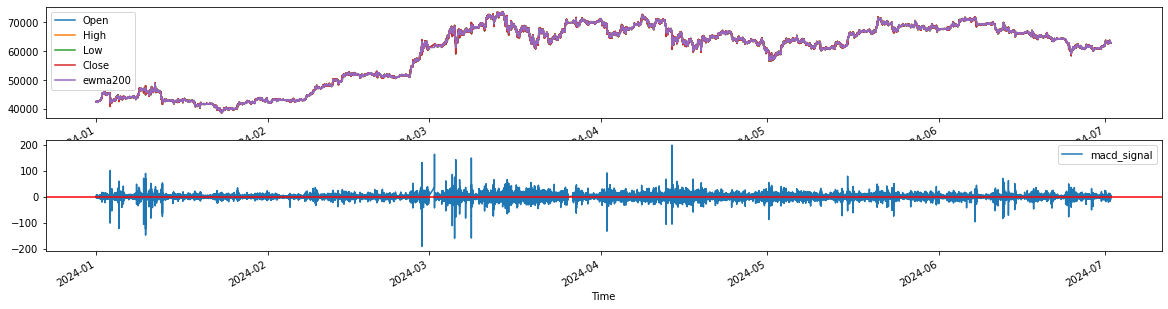

In [3]:
_, ax = plt.subplots(2, 1)
_ = df[["Open", "High", "Low", "Close", "ewma200"]].plot(figsize=(20, 20), ax=ax[0])
_ = df[["macd_signal"]].plot(figsize=(20, 5), ax=ax[1])
_ = ax[1].axhline(0, color = "red")

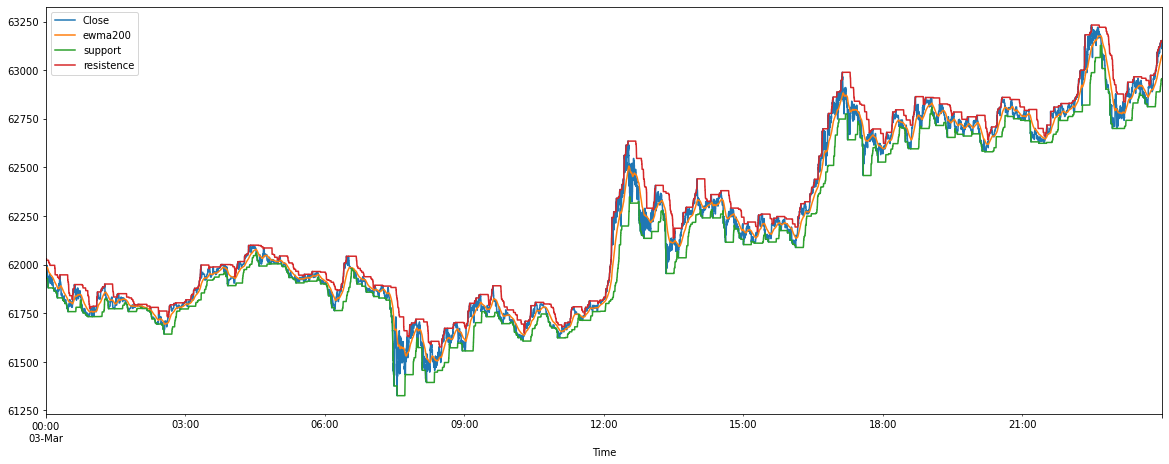

In [32]:
_ = df.loc["2024-03-03"][["Close", "ewma200", "support", "resistence"]].plot(figsize=(20, 7.5))

In [83]:
df_test = df.loc["2024-04-01":"2024-05-01"].copy()

trades = []
inlong, inshort = False, False

RR = 1.5
RISK = 0.001
CAPITAL = 1_000

# profit_target, loss_target = 0, 0

for i in range(1, df_test.shape[0] - 1):

    row, prev_row = df_test.iloc[i], df_test.iloc[i-1]

    # active position
    if inlong:
        if row.Open >= trade_info["take_profit"] or row.High >= trade_info["take_profit"] or row.Low >= trade_info["take_profit"] or row.Close >= trade_info["take_profit"]:
            trades.append(
                {
                    "time": row.name,
                    "trade_price": trade_info["take_profit"],
                    "stop_loss": None,
                    "take_profit": None,
                    "quantity": -1 * trade_info["quantity"]
                }
            )
            trade_info, inlong, inshort = None, False, False

        elif row.Open <= trade_info["stop_loss"] or row.High <= trade_info["stop_loss"] or row.Low <= trade_info["stop_loss"] or row.Close <= trade_info["stop_loss"]:
            trades.append(
                {
                    "time": row.name,
                    "trade_price": trade_info["stop_loss"],
                    "stop_loss": None,
                    "take_profit": None,
                    "quantity": -1 * trade_info["quantity"]
                }
            )
            trade_info, inlong, inshort = None, False, False

        continue

    elif inshort:
        if row.Open <= trade_info["take_profit"] or row.High <= trade_info["take_profit"] or row.Low <= trade_info["take_profit"] or row.Close <= trade_info["take_profit"]:
            trades.append(
                {
                    "time": row.name,
                    "trade_price": trade_info["take_profit"],
                    "stop_loss": None,
                    "take_profit": None,
                    "quantity": -1 * trade_info["quantity"]
                }
            )
            trade_info, inlong, inshort = None, False, False

        elif row.Open >= trade_info["stop_loss"] or row.High >= trade_info["stop_loss"] or row.Low >= trade_info["stop_loss"] or row.Close >= trade_info["stop_loss"]:
            trades.append(
                {
                    "time": row.name,
                    "trade_price": trade_info["stop_loss"],
                    "stop_loss": None,
                    "take_profit": None,
                    "quantity": -1 * trade_info["quantity"]
                }
            )
            trade_info, inlong, inshort = None, False, False

        continue

    # buy
    if prev_row.macd_signal < 0 and row.macd_signal > 0 and row.ewma200 < row.Close:
        trade_info = {
            "time": df_test.iloc[i+1].name, # enter at the next time step
            "trade_price": df_test.iloc[i+1].Open, # at the open price
            "stop_loss": df_test.iloc[i+1].Open * (1 - RISK), #row.support,
        }
        risk = (trade_info["trade_price"] - trade_info["stop_loss"]) / trade_info["trade_price"]
        trade_info["take_profit"] = trade_info["trade_price"] * (1 + risk * RR)
        trade_info["quantity"] = RISK / risk * CAPITAL / trade_info["trade_price"]

        trades.append(trade_info)
        inlong, inshort = True, False
    # sell
    elif prev_row.macd_signal > 0 and row.macd_signal < 0 and row.ewma200 > row.Close:
        trade_info = {
            "time": df_test.iloc[i+1].name, # enter at the next time step
            "trade_price": df_test.iloc[i+1].Open, # at the open price
            "stop_loss": df_test.iloc[i+1].Open * (1 + RISK), #row.resistence,
        }
        risk = (trade_info["stop_loss"] - trade_info["trade_price"]) / trade_info["trade_price"]
        trade_info["take_profit"] = trade_info["trade_price"] * (1 - risk * RR)
        trade_info["quantity"] = -1 * RISK / risk * CAPITAL / trade_info["trade_price"]

        trades.append(trade_info)
        inlong, inshort = False, True

    else:
        trade_info, inlong, inshort = None, False, False

trade_log = pd.DataFrame.from_dict(trades, orient="columns")
trade_log["cash"] = trade_log.eval("trade_price * quantity * -1").cumsum()

Number of trades: 207
Win Rate: 41.06280193236715 %
PnL: 64.99999999999957


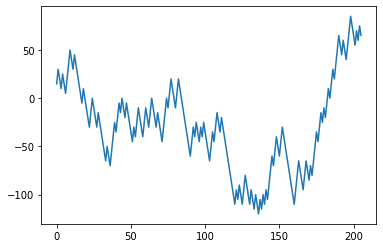

In [84]:
entry_exit = pd.concat([
    trade_log.iloc[::2].drop(columns=["cash"]).reset_index(),
    trade_log.iloc[1::2].drop(columns=["cash"]).reset_index().rename(columns={"time": "exit_time", "trade_price": "exit_price", "quantity": "exit_quantity"})
], axis=1).drop(columns=["index"])

entry_exit["profit"] = entry_exit.eval("(exit_price - trade_price) * quantity")
print("Number of trades:", entry_exit.shape[0])
print("Win Rate:", (entry_exit.profit > 0).sum() / entry_exit.shape[0] * 100, "%")
print("PnL:", entry_exit["profit"].sum())

_ = entry_exit.profit.cumsum().plot()

PnL: 73.45686289701189
Sharpe: 23.127887109987807


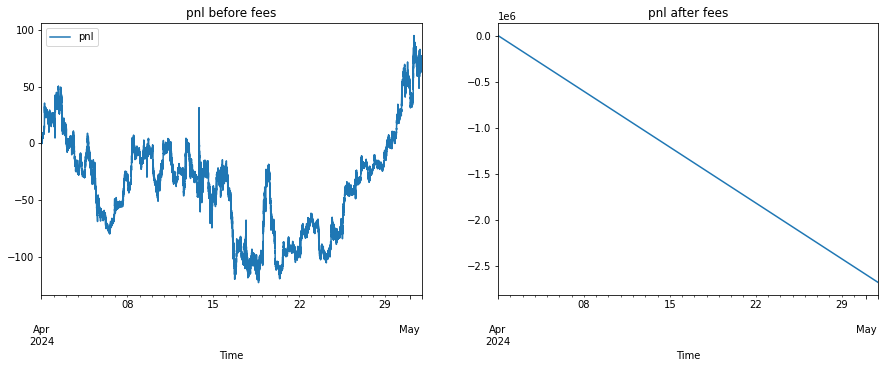

In [85]:
pta_df = df_test.reset_index().merge(trade_log, left_on="Time", right_on="time", how="left").drop(columns=["time"]).set_index("Time")
pta_df = pta_df.assign(
    portfolio = pta_df.quantity.fillna(0).cumsum() * pta_df.Close,
    cash = pta_df.cash.ffill()
)
pta_df["pnl"] = pta_df.eval("portfolio + cash").diff()
pta_df["fees"] = CAPITAL * 0.001

print("PnL:", pta_df["pnl"].sum())

daily_pnl = pta_df["pnl"].groupby(pta_df.index.date).sum()
print("Sharpe:", daily_pnl.mean() * 252 / daily_pnl.std())

_, ax = plt.subplots(1, 2, figsize=(15, 5))
_ = pta_df[["pnl"]].cumsum().plot(ax=ax[0], title="pnl before fees")
_ = pta_df.eval("pnl - fees").cumsum().plot(ax=ax[1], title="pnl after fees")